In [1]:
import ast
import itertools
from itertools import permutations
from sys import maxsize

import numpy as np
from pyproj import Proj
from shapely.geometry import (
    GeometryCollection,
    LineString,
    MultiLineString,
    MultiPoint,
    MultiPolygon,
    Point,
)


In [2]:
points = [
    {"latitude": 37.1726668, "longitude": -3.5996359, "number": 1},
    {"latitude": 37.178399, "longitude": -3.599734, "number": 2},
    {"latitude": 37.170009, "longitude": -3.599067, "number": 3},
    {"latitude": 37.173849, "longitude": -3.60304, "number": 4},
    {"latitude": 37.1743, "longitude": -3.602934, "number": 5},
    {"latitude": 37.174385, "longitude": -3.603439, "number": 6},
    {"latitude": 37.174771, "longitude": -3.606839, "number": 7},
    {"latitude": 37.177224, "longitude": -3.603417, "number": 8},
]

avoid_points = [
    {"latitude": 37.175918, "longitude": -3.605083, "number": 10},
    {"latitude": 37.175180, "longitude": -3.598421, "number": 11},
    {"latitude": 37.180668, "longitude": -3.599708, "number": 12},
]


In [3]:
points[0]["latitude"]


37.1726668

In [4]:
p = Proj(proj="utm", zone=28, ellps="GRS80", preserve_units=False)


In [5]:
p = Proj(
    proj="lcc",
    lat_1=40,
    lat_0=40,
    lon_0=0,
    k_0=0.9988085293,
    x_0=600000,
    y_0=600000,
    a=6378298.3,
    rf=294.73,
    pm=-3.687375,
    units="m",
    type="crs",
)


In [6]:
p = Proj(proj="utm", zone=28, ellps="WGS84", preserve_units=False)


In [7]:
# a more specific projection for Spain or Europe let our points isolated, this projection works ok for this points
p = Proj(
    proj="utm",
    zone=10,
    ellps="WGS84",
    units="m",
)


In [8]:
points_good = [p(point["longitude"], point["latitude"]) for point in points]
points_good = [Point(point) for point in points_good]
points_bad = [p(point["longitude"], point["latitude"]) for point in avoid_points]
points_bad = [Point(point).buffer(200) for point in points_bad]


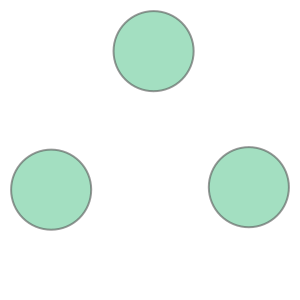

In [9]:
MultiPolygon(points_bad)


In [10]:
points_bad[0].area


125461.93962163804

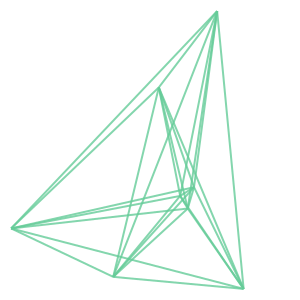

In [11]:
multilines = []
for point1, point2 in itertools.combinations(points_good, 2):
    multilines.append(LineString([point1, point2]))
point_lines = MultiLineString(multilines)
point_lines


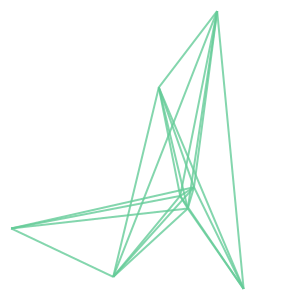

In [12]:
distance_matrix = np.zeros((len(points), len(points)))
multilines_good = []
for ix1, ix2 in itertools.combinations(np.arange(8), 2):
    point1 = points_good[ix1]
    point2 = points_good[ix2]
    line = LineString([point1, point2])
    emptiness = []
    for point_bad in points_bad:
        emptiness.append(point_bad.intersection(line).is_empty)
    if all(emptiness):
        multilines_good.append(line)
        distance_matrix[ix1, ix2] = line.length
        distance_matrix[ix2, ix1] = line.length
    else:
        distance_matrix[ix1, ix2] = 99999999999
        distance_matrix[ix2, ix1] = 99999999999

point_lines_good = MultiLineString(multilines_good)
point_lines_good


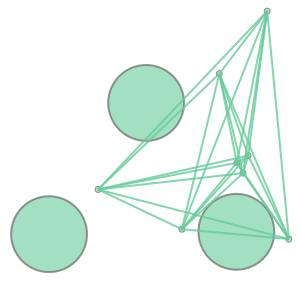

In [13]:
GeometryCollection([MultiPoint(points_good), MultiPolygon(points_bad), point_lines])


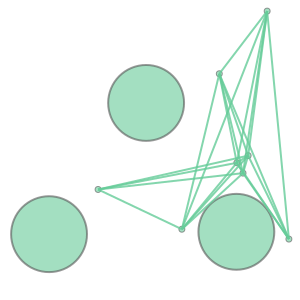

In [14]:
GeometryCollection(
    [MultiPoint(points_good), MultiPolygon(points_bad), point_lines_good]
)


### travelling salesman problem

In [15]:
V = len(points)

# implementation of traveling Salesman Problem
def travellingSalesmanProblem(graph, s):

    # store all vertex apart from source vertex
    vertex = []
    for i in range(V):
        if i != s:
            vertex.append(i)

    # store minimum weight Hamiltonian Cycle
    min_path = maxsize
    next_permutation = permutations(vertex)
    for i in next_permutation:

        # store current Path weight(cost)
        current_pathweight = 0

        # compute current path weight
        k = s
        for j in i:
            current_pathweight += graph[k][j]
            k = j
        current_pathweight += graph[k][s]

        # update minimum
        if current_pathweight < min_path:
            path = str(i)
        min_path = min(min_path, current_pathweight)

    return min_path, path


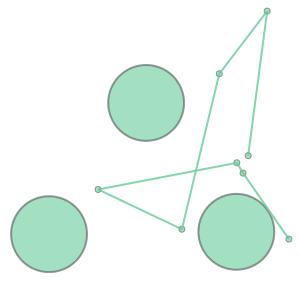

In [16]:
start = 3
min_dist, min_path = travellingSalesmanProblem(distance_matrix, start)
x = list(ast.literal_eval(min_path))
x.insert(0, start)
opt_path = []
for ix1, ix2 in itertools.pairwise(x):
    opt_path.append(LineString([points_good[ix1], points_good[ix2]]))
opt_path_lines = MultiLineString(opt_path)
GeometryCollection([MultiPoint(points_good), MultiPolygon(points_bad), opt_path_lines])
